In [1]:
# default_exp data.tsloader_fast

In [2]:
#hide
%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
from nixtla.data.tsdataset import TimeSeriesDataset
from collections import defaultdict

In [9]:
#export
# TODO: pensar variable shuffle para compatibilidad con dataloader de pytorch y keras
#.      por el momento tenemos solo validacion boostrapeada, no existe modo no shuffle
#.      para evaluacion no estocástica, nuestra validación está hackeada.
class TimeSeriesLoader(object):
    def __init__(self,
                 ts_dataset:TimeSeriesDataset,
                 model:str,
                 offset:int,
                 window_sampling_limit: int, 
                 input_size: int,
                 output_size: int,
                 idx_to_sample_freq: int, # TODO: Usada en hack ENORME para window frequency sampling
                 batch_size: int,
                 is_train_loader: bool,
                 shuffle:bool):
        """
        """
        # Dataloader attributes
        self.model = model
        self.window_sampling_limit = window_sampling_limit
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.idx_to_sample_freq = idx_to_sample_freq
        self.offset = offset
        self.ts_dataset = ts_dataset
        self.t_cols = self.ts_dataset.t_cols
        self.is_train_loader = is_train_loader # Boolean variable for train and validation mask
        self.shuffle = shuffle # Boolean to shuffle data, useful for validation
       
        # Create rolling window matrix in advanced for faster access to data and broadcasted s_matrix
        self._create_sample_data()

    def _update_sampling_windows_idxs(self):

        # Only sample during available windows with at least one active output mask and input mask
        #available_condition = t.sum(self.ts_windows[:, self.t_cols.index('available_mask'), :self.input_size], axis=1)
        sample_condition = t.sum(self.ts_windows[:, self.t_cols.index('sample_mask'), -self.output_size:], axis=1)
        sampling_idx = t.nonzero(sample_condition)
        sampling_idx = list(sampling_idx.flatten().numpy())

        assert len(sampling_idx)>0, 'Check the data and masks as sample_idxs are empty'
        return sampling_idx

    def _create_windows_tensor(self):
        """
        Comment here
        TODO: Cuando creemos el otro dataloader, si es compatible lo hacemos funcion transform en utils
        """
        # Memory efficiency is gained from keeping across dataloaders common ts_tensor in dataset
        # Filter function is used to define train tensor and validation tensor with the offset
        # Default ts_idxs=ts_idxs sends all the data
        tensor, right_padding = self.ts_dataset.get_filtered_ts_tensor(offset=self.offset, output_size=self.output_size,
                                                                        window_sampling_limit=self.window_sampling_limit)
        tensor = t.Tensor(tensor)

        # Outsample mask checks existance of values in ts, train_mask mask is used to filter out validation
        # is_train_loader inverts the train_mask in case the dataloader is in validation mode
        if self.is_train_loader:
            tensor[:, self.t_cols.index('sample_mask'), :] = \
                tensor[:, self.t_cols.index('available_mask'), :] * tensor[:, self.t_cols.index('sample_mask'), :]
            
            # Since Xt from future is returned in tensor, protection from leakage is needed
            #tensor[:, self.t_cols.index('y'), -self.output_size:] = 0 # overkill to ensure no validation leakage
            #tensor[:, self.t_cols.index('sample_mask'), -self.output_size:] = 0

        padder = t.nn.ConstantPad1d(padding=(self.input_size, right_padding), value=0)
        tensor = padder(tensor)

        # Creating rolling windows and 'flattens' them
        windows = tensor.unfold(dimension=-1, size=self.input_size + self.output_size, step=self.idx_to_sample_freq)
        # n_serie, n_channel, n_time, window_size -> n_serie, n_time, n_channel, window_size
        #print(f'n_serie, n_channel, n_time, window_size = {windows.shape}')
        windows = windows.permute(0,2,1,3)
        #print(f'n_serie, n_time, n_channel, window_size = {windows.shape}')
        windows = windows.reshape(-1, self.ts_dataset.n_channels, self.input_size + self.output_size)

        # Broadcast s_matrix: This works because unfold in windows_tensor, orders: time, serie
        s_matrix = self.ts_dataset.s_matrix.repeat(repeats=int(len(windows)/self.ts_dataset.n_series), axis=0)

        return windows, s_matrix, tensor

    def __len__(self):
        return len(self.len_series)

    def __iter__(self):
        if self.shuffle:
            sample_idxs = np.random.choice(a=self.windows_sampling_idx,
                                           size=len(self.windows_sampling_idx), replace=False)
        else:
            sample_idxs = self.windows_sampling_idx

        n_batches = int(np.ceil(len(sample_idxs) / self.batch_size)) # Must be multiple of batch_size for paralel gpu
        
        for idx in range(n_batches):
            ws_idxs = sample_idxs[(idx * self.batch_size) : (idx + 1) * self.batch_size]
            batch = self.__get_item__(index=ws_idxs)
            yield batch

    def __get_item__(self, index):
        if self.model == 'nbeats':
            return self._windows_batch(index)
        elif self.model == 'esrnn':
            #return self._full_series_batch(index)
            assert 1<0, 'Hierarchical sampling not implemented'
        else:
            assert 1<0, 'error'

    def _windows_batch(self, index):
        """ NBEATS, TCN models """

        # Access precomputed rolling window matrix (RAM intensive)
        windows = self.ts_windows[index]
        s_matrix = self.s_matrix[index]

        insample_y = windows[:, self.t_cols.index('y'), :self.input_size]
        insample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('available_mask'), :self.input_size]
        available_mask = windows[:, self.t_cols.index('available_mask'), :self.input_size]

        outsample_y = windows[:, self.t_cols.index('y'), self.input_size:]
        outsample_x = windows[:, (self.t_cols.index('y')+1):self.t_cols.index('available_mask'), self.input_size:]
        sample_mask = windows[:, self.t_cols.index('sample_mask'), self.input_size:]

        batch = {'s_matrix': s_matrix,
                 'insample_y': insample_y, 'insample_x':insample_x, 'insample_mask':available_mask,
                 'outsample_y': outsample_y, 'outsample_x':outsample_x, 'outsample_mask':sample_mask}
        return batch

    # def _full_series_batch(self, index):
    #     """ ESRNN, RNN models """
        
    #     print("[index]", index)
    #     print("self.ts_tensor.shape", self.ts_tensor.shape)

    #     ts_tensor = self.ts_tensor[index]

    #     # Trim batch to shorter time series to avoid zero padding
    #     insample_y = ts_tensor[:, self.t_cols.index('y'), :]
    #     batch_len_series = np.array(self.ts_dataset.len_series)[index]
    #     min_batch_len = np.min(batch_len_series)
    #     insample_y = insample_y[:, -min_batch_len:]

    #     insample_x = ts_tensor[:, self.t_cols.index('y')+1:self.t_cols.index('insample_mask'), :]
    #     insample_x = insample_x[:, -min_batch_len:]

    #     s_matrix = self.ts_dataset.s_matrix[index]

    #     batch = {'insample_y': insample_y, 'idxs': index, 'insample_x': insample_x, 's_matrix': s_matrix}

    #     return batch

    def _create_sample_data(self):
        """
        """
        # print('Creating windows matrix ...')
        # Create rolling window matrix for fast information retrieval
        self.ts_windows, self.s_matrix, _ = self._create_windows_tensor()
        self.n_windows = len(self.ts_windows)
        self.windows_sampling_idx = self._update_sampling_windows_idxs()

    def update_offset(self, offset):
        if offset == self.offset:
            return # Avoid extra computation
        self.offset = offset
        self._create_train_data()

    def get_meta_data_col(self, col):
        return self.ts_dataset.get_meta_data_col(col)

    def get_n_variables(self):
        return self.ts_dataset.n_x, self.ts_dataset.n_s

    def get_n_series(self):
        return self.ts_dataset.n_series

    def get_max_len(self):
        return self.ts_dataset.max_len

    def get_n_channels(self):
        return self.ts_dataset.n_channels

    def get_X_cols(self):
        return self.ts_dataset.X_cols

    def get_frequency(self):
        return self.ts_dataset.frequency

In [25]:
import matplotlib.pyplot as plt
from nixtla.data.datasets.epf import EPF, EPFInfo

def get_last_n_hours_mask_df(Y_df, n_hours):
    # Creates outsample_mask
    # train 1 validation 0

    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(n_hours)
    last_df['mask'] = 1

    last_df = last_df[['unique_id', 'ds', 'mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['mask'] = mask_df['mask'].fillna(0)    # The first len(Y)-n_hours used as train

    mask_df = mask_df[['unique_id', 'ds', 'mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    return mask_df

val_ds = 2 * 365
#args = pd.Series({'dataset': ['NP', 'PJM', 'BE', 'FR']})
args = pd.Series({'dataset': ['NP']})

Y_df, Xt_df, S_df = EPF.load_groups(directory='data', groups=args.dataset)

mask_df = get_last_n_hours_mask_df(Y_df, n_hours=val_ds*24)
mask_df['available_mask'] = np.ones(len(mask_df))
mask_df['sample_mask'] = (1-mask_df['mask'].values)
mask = mask_df['sample_mask'].values

#print(f'Dataset: {args.dataset}')
#print("Xt_df.columns", Xt_df.columns)
print('X: time series features, of shape (#hours, #times,#features): \t' + str(Xt_df.shape))
if S_df is not None:
    print('S: static features, of shape (#series,#features+unique_id): \t' + str(S_df.shape))
print('Y: target series (in X), of shape (#hours, #times): \t \t' + str(Y_df.shape))
print("\n")

print("Train Validation splits")
print(mask_df.groupby(['mask', 'unique_id']).ds.max())
print(mask_df.groupby(['mask', 'unique_id']).ds.min())
print(f'Train insample percentage {np.round(sum(mask)/len(Y_df),2)}, \
        {sum(mask)} hours = {np.round(sum(mask)/(24*365),2)} years')
print(f'Train outsample percentage {np.round(sum(1-mask)/len(Y_df),2)}, \
        {sum(1-mask)} hours = {np.round(sum(1-mask)/(24*365),2)} years')
#Y_df.head()
print('\n')

dataset = TimeSeriesDataset(Y_df=Y_df, S_df=S_df, X_df=Xt_df, mask_df=mask_df)

X: time series features, of shape (#hours, #times,#features): 	(34944, 12)
S: static features, of shape (#series,#features+unique_id): 	(1, 2)
Y: target series (in X), of shape (#hours, #times): 	 	(34944, 3)


Train Validation splits
mask  unique_id
0.0   NP          2014-12-27 23:00:00
1.0   NP          2016-12-26 23:00:00
Name: ds, dtype: datetime64[ns]
mask  unique_id
0.0   NP          2013-01-01
1.0   NP          2014-12-28
Name: ds, dtype: datetime64[ns]
Train insample percentage 0.5,         17424.0 hours = 1.99 years
Train outsample percentage 0.5,         17520.0 hours = 2.0 years


Processing dataframes ...
Creating ts tensor ...


In [26]:
dataset.ts_tensor

array([[[3.1050e+01, 3.0470e+01, 2.8920e+01, ..., 2.6820e+01,
         2.6650e+01, 2.5680e+01],
        [4.2497e+04, 4.1463e+04, 4.0812e+04, ..., 4.5471e+04,
         4.4386e+04, 4.3017e+04],
        [2.7980e+03, 2.4170e+03, 2.0360e+03, ..., 2.1290e+03,
         1.8270e+03, 1.6890e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 1.0000e+00,
         1.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.0000e+00, 1.0000e+00, ..., 0.0000e+00,
         0.0000e+00, 0.0000e+00]]])

In [27]:
ts_loader = TimeSeriesLoader(ts_dataset=dataset,
                             model='nbeats',
                             offset=0,
                             window_sampling_limit=365*4*24, 
                             input_size=7*24,
                             output_size=24,
                             idx_to_sample_freq=1,
                             batch_size= 128,
                             is_train_loader=True,
                             shuffle=False)

In [28]:
dataloader = iter(ts_loader)
batch = next(dataloader)
insample_y = batch['insample_y']
insample_x = batch['insample_x']
insample_mask = batch['insample_mask']
outsample_y = batch['outsample_y']
outsample_x = batch['outsample_x']
outsample_mask = batch['outsample_mask']

print("epf_dataset.t_cols", dataset.t_cols)
print("ts_loader.input_size", ts_loader.input_size)
print("ts_loader.output_size", ts_loader.output_size)
print("insample_y.shape", insample_y.shape)
print("insample_x.shape", insample_x.shape)
print("outsample_y.shape", outsample_y.shape)
print("outsample_x.shape", outsample_x.shape)

epf_dataset.t_cols ['y', 'Exogenous1', 'Exogenous2', 'week_day', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'available_mask', 'sample_mask']
ts_loader.input_size 168
ts_loader.output_size 24
insample_y.shape torch.Size([128, 168])
insample_x.shape torch.Size([128, 10, 168])
outsample_y.shape torch.Size([128, 24])
outsample_x.shape torch.Size([128, 10, 24])


In [29]:
# insample_y

In [30]:
# outsample_x

insample_y.shape torch.Size([128, 168])
insample_y.shape torch.Size([128, 168])
insample_y.shape torch.Size([128, 168])
check.shape (384, 168)
Checking order for unshuffled validation


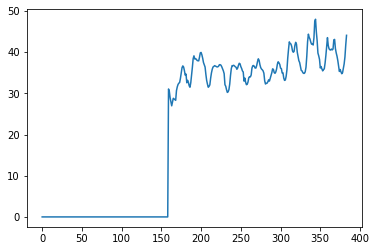

In [31]:
check_list = []
for i, batch in enumerate(ts_loader):
    insample_y = batch['insample_y']
    insample_x = batch['insample_x']
    insample_mask = batch['insample_mask']
    outsample_y = batch['outsample_y']
    outsample_x = batch['outsample_x']
    outsample_mask = batch['outsample_mask']

    #print("on_dataset.t_cols", on_dataset.t_cols)
    #print("ts_loader.input_size", ts_loader.input_size)
    #print("ts_loader.output_size", ts_loader.output_size)
    print("insample_y.shape", insample_y.shape)
    #print("insample_x.shape", insample_x.shape)
    #print("outsample_y.shape", outsample_y.shape)
    #print("outsample_x.shape", outsample_x.shape)

    check_list += [insample_y]

    if i>1: break

check = np.vstack(check_list)
print("check.shape", check.shape)
print("Checking order for unshuffled validation")
plt.plot(check[:,9])
plt.show()